In [7]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imutils
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import math
from tensorflow.keras.preprocessing import image as IMAGE
# from google.colab.patches import cv2.imshow
from imutils import face_utils
import dlib
import keras
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from sklearn.neighbors import KNeighborsClassifier
import pickle
# from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import render_template, request, jsonify
from sklearn.metrics import accuracy_score
from IPython.display import display, Javascript
#from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt

#Face Detection Model Initialization
prototxt =  model_path = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\deploy.prototxt"
dnn_path = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\res10_300x300_ssd_iter_140000.caffemodel"
face_detection_model = cv2.dnn.readNetFromCaffe(prototxt, dnn_path)

#Facial Landmarks Detector Model
model_path = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\shape_predictor_5_face_landmarks.dat"
predictor = dlib.shape_predictor(model_path)

#Path for directories from the Database
train_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\trainset"
roi_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\roiset"
clahe_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\claheset"
test_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\testset"
aug_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\augmentset"
test_roi_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\testroiset"
test_clahe_dir =r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\testclaheset"
val_dir = r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\valset"

#Test Subjects Names
people_in_db = {
    "hodsir" : "HodSir",
    "pavan" : "Pavan",
    "ramgopal": "Ramgopal",
    "jyoshna" : "Jyoshna",
    "sadaa": "Sadaa",
    "sai" : "Sai",
    "sravan" : "Sravan",
    "chaitanya" : "Chaitanya",
    "ibrahim" : "Ibrahim",
    "venu" : "Venu",
    "joseph" : "Joseph",
    "sivakalyan" : "SivaKalyan"
}

#a and b values for changing extent of region of interest
a = 1.25
b = 0.95

#Augementor for expanding training Data
augmentor = ImageDataGenerator(
		rotation_range=20,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		vertical_flip=True,
    brightness_range=[0.5,1.5],
    zoom_range = 0.3,
		fill_mode="nearest")

#VGG16 Feature extractor
vggmodel = VGG16(weights='imagenet', include_top=False)
#KNN Classifiers
left_model = KNeighborsClassifier(n_neighbors=3, weights='distance')
right_model = KNeighborsClassifier(n_neighbors=3, weights='distance')
#Dictionaries to calculate avg sum of recognition probabilities
classes_prob_left = {}
classes_prob_right = {}
avg_prob = {}

def augmentation(train_dir):
  temp = 0
  for person in os.listdir(train_dir):
    person_dir = os.path.join(train_dir, person)
    save_dir = os.path.join(aug_dir,person)
    for img in os.listdir(person_dir):
      print("augmentation on " + person)
      img_path=os.path.join(person_dir, img)
      to_augment = load_img(img_path)
      to_augment = img_to_array(to_augment)
      to_augment = np.expand_dims(to_augment, axis=0)
      total_images = 0
      generator = augmentor.flow(to_augment, batch_size=1, save_to_dir=save_dir, save_prefix=person, save_format="jpg")
      for to_augment in generator:
        total_images += 1
        if total_images == 10:
          break
  print("STEP 1: DATA AUGMENTATION DONE !!!")

#Detect Face region using DNN
def get_face(image, model):
  h, w = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  model.setInput(blob)
  detected_face = model.forward()
  for i in range(detected_face.shape[2]):
    confidence = detected_face[0, 0, i, 2]
    if confidence > 0.5:
      box = detected_face[0, 0, i, 3:7] * np.array([w, h, w, h])
      (x, y, x1, y1) = box.astype("int")
      face = [x, y, x1, y1]
    return face

#Convert face region bounding box to square for consistency
def get_square_face(image, face):
  offset = int(abs((face[3] - face[1]) * 0.1))
  offset_arr = [0, offset]
  left_x = face[0] + offset_arr[0]
  top_y = face[1] + offset_arr[1]
  right_x = face[2] + offset_arr[0]
  bottom_y = face[3] + offset_arr[1]
  shifted_box = [left_x, top_y, right_x, bottom_y]
  bb_width = right_x - left_x
  bb_height = bottom_y - top_y
  diff = bb_height - bb_width
  delta = int(abs(diff) / 2)
  if diff == 0:
    pass
  elif diff > 0:
    left_x -= delta
    right_x += delta
    if diff % 2 == 1:
      right_x += 1
  else:
    top_y -= delta
    bottom_y += delta
    if diff % 2 == 1:
      bottom_y += 1
  assert ((right_x - left_x) == (bottom_y - top_y)), 'Box is not square.'
  facebox = [left_x, top_y, right_x, bottom_y]
  h, w = image.shape[:2]
  if facebox[0] < 0:
    facebox[0] = 0
  if facebox[1] < 0:
    facebox[1] = 0
  if facebox[2] > w:
    facebox[2] = w
  if facebox[3] > h:
    facebox[3] = h
  face_img = image[facebox[1]: facebox[3], facebox[0]: facebox[2]]
  face_img = cv2.resize(face_img, (128, 128))
  face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
  return facebox

def euclidean_dist(x, y):
  distance = 0.0
  for i in range(len(x)-1):
    distance += (abs(x[i] - y[i]))**2
  return math.sqrt(distance)

def roi_extraction(directory):
  l_outer = 37
  l_inner = 40
  r_outer = 46
  r_inner = 43
  canthus_attr=[37,40,43,46]
  person_id = 1
  total_people = 24
  for person in os.listdir(directory):
    person_dir = os.path.join(directory, person)
    print(str(person_id) + " of " + str(total_people) + ": PERFORMING ROI EXTRACTION ON", people_in_db[person])
    for picture in os.listdir(person_dir):
      img_path=os.path.join(person_dir, picture)
      img = cv2.imread(img_path)
      if img is None:
        print(f"Error: Could not read image {img_path}")
        continue
      img = imutils.resize(img, width=400)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img.astype(np.uint8)
      # print(f"Shape: {img.shape}, Data Type: {img.dtype}")
      # print(isinstance(img, np.ndarray))
      # print(f"Max pixel value: {img.max()}, Min pixel value: {img.min()}")
      # print(f"Image type: {type(img)}")
      img_copy = img.copy()
      img_copy2 = img.copy()
      img_copy3 = img.copy()
      face = get_face(img, face_detection_model)
      facebox = get_square_face(img, face)
      #cv2.rectangle(img_copy, (facebox[0], facebox[1]),(facebox[2],facebox[3]), (0,0,255),2)
      #print("DETECTED FACE REGION\n")
      #cv2.imshow(img_copy)
      #print("\n\n\n")
      facebox = dlib.rectangle(facebox[0],facebox[1],facebox[2],facebox[3])
      shape = predictor(img, facebox)
      shape = face_utils.shape_to_np(shape)
      for (i, (x, y)) in enumerate(shape):
        if i == 4 :
          pass
        else:
          cv2.circle(img_copy2, (x, y), 1, (0, 0, 255), 2)
      #print("DETECTED FACIAL LANDMARKS")
      #cv2.imshow(img_copy2)
      #print("\n\n\n")
      D_left = euclidean_dist(shape[3], shape[2])
      D_right = euclidean_dist(shape[0], shape[1])
      Lpx = (shape[2][0] + shape[3][0])/2
      Lpy = (shape[2][1] + shape[3][1])/2
      Rpx = (shape[0][0] + shape[1][0])/2
      Rpy = (shape[0][1] + shape[1][1])/2
      tlc_left = (int(Lpx - a * D_left) , int(Lpy - b * D_left))
      brc_left = (int(Lpx + a * D_left) , int(Lpy + b * D_left))
      tlc_right = (int(Rpx - a * D_right) , int(Rpy - b * D_right))
      brc_right = (int(Rpx + a * D_right) , int(Rpy + b * D_right))
      cv2.rectangle(img_copy3, tlc_left, brc_left, (0, 255, 0), 2)
      cropped_left = img[tlc_left[1]:brc_left[1], tlc_left[0]:brc_left[0]]
      #cv2.rectangle(img_copy3, tlc_right, brc_right, (0, 255, 0), 2)
      #print("DETECTED PERIOCULAR REGIONS")
      #cv2.imshow(img_copy3)
      #print("\n\n\n")
      cropped_right = img[tlc_right[1]:brc_right[1], tlc_right[0]:brc_right[0]]
      cropped_left = img[tlc_left[1]:brc_left[1], tlc_left[0]:brc_left[0]]
      #print("CROPPED PERIOCULAR REGIONS")
      #cv2.imshow(cropped_right)
      #cv2.imshow(cropped_left)
      #print("\n\n\n")
      cropped_name_left = "left_" + picture
      cropped_name_right = "right_" + picture
      cropped_path = os.path.join(roi_dir, person)
      cropped_path_left = os.path.join(cropped_path, "left")
      cropped_path_right = os.path.join(cropped_path, "right")
      cropped_path_left = os.path.join(cropped_path_left, cropped_name_left)
      cropped_path_right = os.path.join(cropped_path_right, cropped_name_right)
      #print(cropped_path_left, cropped_path_right)
      cv2.imwrite (cropped_path_left, cropped_left)
      cv2.imwrite (cropped_path_right, cropped_right)
    person_id+=1
  print("STEP 1 of 3: ROI EXTRACTION COMPLETED\n")

def clahe_eye(directory, left_right, person):
  for picture in os.listdir(directory):
    img_path=os.path.join(directory, picture)
    img = cv2.imread(img_path)
    #cv2.imshow(picture)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    v = clahe.apply(v)
    hsv = cv2.merge([h,s,v])
    clahe_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    #print("CLAHE PERFORMED\n")
    #cv2.imshow(clahe_image)
    #print("\n\n\n")
    clahe_name = 'clahe_' + picture
    clahe_path = os.path.join(clahe_dir, person)
    if left_right == 0:
      clahe_path = os.path.join(clahe_path,"left")
    else:
      clahe_path = os.path.join(clahe_path,"right")
    clahe_path = os.path.join(clahe_path,clahe_name)
    #print(clahe_path)
    cv2.imwrite(clahe_path,clahe_image)

def clahe_preprocessing(directory):
  person_id = 1
  total_people = 24
  for person in os.listdir(directory):
    print(str(person_id) + " of " + str(total_people) + ": PERFORMING CLAHE PRE-PROCESSING ON", people_in_db[person])
    person_dir = os.path.join(roi_dir, person)
    person_dir_left = os.path.join(person_dir, "left")
    person_dir_right = os.path.join(person_dir, "right")
    clahe_eye(person_dir_left, 0, person)
    clahe_eye(person_dir_right, 1, person)
    person_id+=1
  print("STEP 2 of 3: CLAHE PRE-PROCESSING COMPLETED")

def train_classifier():
  all_features_left = []
  all_features_right = []
  labels_left = []
  labels_right = []
  person_id = 1
  total_people = 24
  for person in os.listdir(clahe_dir):
    print(str(person_id) + " of " + str(total_people) + ": TRAINING ON", people_in_db[person])
    person_dir = os.path.join(clahe_dir, person)
    person_dir_left = os.path.join(person_dir, "left")
    person_dir_right = os.path.join(person_dir, "right")
    for picture in os.listdir(person_dir_left):
      label = person + "_left"
      img_path=os.path.join(person_dir_left, picture)
      #print(img_path)
      img = IMAGE.load_img(img_path, target_size=(224, 224))
      img_arr = IMAGE.img_to_array(img)
      img_arr = np.expand_dims(img_arr, axis=0)
      img_arr = preprocess_input(img_arr)
      feature_vector = vggmodel.predict(img_arr)
      #print(features)
      vgg16_feature_np = np.array(feature_vector)
      vgg16_feature_np = vgg16_feature_np.flatten()
      all_features_left.append(vgg16_feature_np)
      labels_left.append(label)
    for picture in os.listdir(person_dir_right):
      label = person + "_right"
      img_path=os.path.join(person_dir_right, picture)
      #print(img_path)
      img = IMAGE.load_img(img_path, target_size=(224, 224))
      img_arr = IMAGE.img_to_array(img)
      img_arr = np.expand_dims(img_arr, axis=0)
      img_arr = preprocess_input(img_arr)
      feature_vector = vggmodel.predict(img_arr)
      #print(features)
      vgg16_feature_np = np.array(feature_vector)
      vgg16_feature_np = vgg16_feature_np.flatten()
      all_features_right.append(vgg16_feature_np)
      labels_right.append(label)
    person_id+=1
  left_model.fit(all_features_left, labels_left)
  right_model.fit(all_features_right, labels_right)
  print("STEP 3 of 3: TRAINING MODEL COMPLETED")

def print_image(image):
  # Convert BGR to RGB (Matplotlib expects RGB)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Display image
  plt.imshow(image)
  plt.axis("off")  # Hide axes
  plt.show()

def create_model():
  roi_extraction(train_dir)
  clahe_preprocessing(roi_dir)
  train_classifier()
  pickle.dump(left_model, open(r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\left.sav", 'wb'))
  pickle.dump(right_model, open(r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\right.sav", 'wb'))
  return "done"

def roi_extraction_test(img_path):
  picture = "1.jpg"
  l_outer = 37
  l_inner = 40
  r_outer = 46
  r_inner = 43
  canthus_attr=[37,40,43,46]
  img = cv2.imread(img_path)
  img = imutils.resize(img, width=400)
  #cv2.imshow(img)
  img_copy = img.copy()
  img_copy2 = img.copy()
  img_copy3 = img.copy()
  face = get_face(img, face_detection_model)
  print(face)
  if face == None:
    print("NO FACE SEEN")
  facebox = get_square_face(img, face)
  cv2.rectangle(img_copy, (facebox[0], facebox[1]),(facebox[2],facebox[3]), (0,0,255),2)
  print("DETECTED FACE REGION\n")
  print_image(img_copy)
  # cv2.imshow("Image",img_copy)
  print("\n\n\n")
  facebox = dlib.rectangle(facebox[0],facebox[1],facebox[2],facebox[3])
  shape = predictor(img, facebox)
  shape = face_utils.shape_to_np(shape)
  for (i, (x, y)) in enumerate(shape):
    if i == 4 :
      pass
    else:
      cv2.circle(img_copy, (x, y), 1, (0, 0, 255), 2)
  print("DETECTED FACIAL LANDMARKS")
  # cv2.imshow("Image",img_copy2)
  print_image(img_copy2)
  print("\n\n\n")
  D_left = euclidean_dist(shape[3], shape[2])
  D_right = euclidean_dist(shape[0], shape[1])
  Lpx = (shape[2][0] + shape[3][0])/2
  Lpy = (shape[2][1] + shape[3][1])/2
  Rpx = (shape[0][0] + shape[1][0])/2
  Rpy = (shape[0][1] + shape[1][1])/2
  tlc_left = (int(Lpx - a * D_left) , int(Lpy - b * D_left))
  brc_left = (int(Lpx + a * D_left) , int(Lpy + b * D_left))
  tlc_right = (int(Rpx - a * D_right) , int(Rpy - b * D_right))
  brc_right = (int(Rpx + a * D_right) , int(Rpy + b * D_right))
  cv2.rectangle(img_copy3, tlc_left, brc_left, (0, 255, 0), 2)
  cropped_left = img[tlc_left[1]:brc_left[1], tlc_left[0]:brc_left[0]]
  cv2.rectangle(img_copy3, tlc_right, brc_right, (0, 255, 0), 2)
  print("DETECTED PERIOCULAR REGIONS")
  # cv2.imshow("Image",img_copy3)
  print_image(img_copy3)
  print("\n\n\n")
  #cv2.imshow(img_copy2)
  cropped_right = img[tlc_right[1]:brc_right[1], tlc_right[0]:brc_right[0]]
  cropped_left = img[tlc_left[1]:brc_left[1], tlc_left[0]:brc_left[0]]
  print("CROPPED PERIOCULAR REGIONS")
  # cv2.imshow("Image",cropped_right)
  print_image(cropped_right)
  # cv2.imshow("Image",cropped_left)
  print_image(cropped_left)
  print("\n\n\n")
  cropped_name_left = "left_test_" + picture
  cropped_name_right = "right_test_" + picture
  cropped_path = test_roi_dir
  cropped_path_left = os.path.join(cropped_path, "left")
  cropped_path_right = os.path.join(cropped_path, "right")
  cropped_path_left = os.path.join(cropped_path_left, cropped_name_left)
  cropped_path_right = os.path.join(cropped_path_right, cropped_name_right)
  #print(cropped_path_left, cropped_path_right)
  cv2.imwrite (cropped_path_left, cropped_left)
  cv2.imwrite (cropped_path_right, cropped_right)

def clahe_eye_test(directory, left_right):
  for picture in os.listdir(directory):
    img_path=os.path.join(directory, picture)
    img = cv2.imread(img_path)
    #cv2.imshow(picture)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    v = clahe.apply(v)
    hsv = cv2.merge([h,s,v])
    clahe_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    print("CLAHE PERFORMED\n")
    # cv2.imshow("Image",clahe_image)
    print_image(clahe_image)
    print("\n\n\n")
    #cv2.imshow(clahe_image)
    clahe_name = 'testclahe_' + picture
    clahe_path = test_clahe_dir
    if left_right == 0:
      clahe_path = os.path.join(clahe_path,"left")
    else:
      clahe_path = os.path.join(clahe_path,"right")
    clahe_path = os.path.join(clahe_path,clahe_name)
    #print(clahe_path)
    cv2.imwrite(clahe_path,clahe_image)

def clahe_preprocessing_test(directory):
    test_dir_left = os.path.join(directory, "left")
    test_dir_right = os.path.join(directory, "right")
    clahe_eye_test(test_dir_left, 0)
    clahe_eye_test(test_dir_right, 1)

def predict_person(img_path):
  loaded_left = pickle.load(open(r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\left.sav", 'rb'))
  loaded_right = pickle.load(open(r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\models\right.sav", 'rb'))
  roi_extraction_test(img_path)
  clahe_preprocessing_test(test_roi_dir)
  test_clahe_dir_left = os.path.join(test_clahe_dir, "left")
  test_clahe_dir_right = os.path.join(test_clahe_dir, "right")
  for pic in os.listdir(test_clahe_dir_left):
    left_eye_path = os.path.join(test_clahe_dir_left, pic)
    left_eye = IMAGE.load_img(left_eye_path, target_size=(224, 224))
    img_arr = IMAGE.img_to_array(left_eye)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    feature_vec = vggmodel.predict(img_arr)
    vgg16_feature_np = np.array(feature_vec)
    vgg16_feature_np = vgg16_feature_np.flatten()
    rec_left = loaded_left.predict([vgg16_feature_np])
    p_pred_left = loaded_left.predict_proba([vgg16_feature_np])
    #print(rec_left, p_pred_left)
    rec_left = rec_left.tolist()
    rec_left = rec_left[0]
    person_left = rec_left.replace("_left", "")
    #print(person_left)
  for pic in os.listdir(test_clahe_dir_right):
    right_eye_path = os.path.join(test_clahe_dir_right, pic)
    right_eye = IMAGE.load_img(right_eye_path, target_size=(224, 224))
    img_arr = IMAGE.img_to_array(right_eye)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    feature_vec = vggmodel.predict(img_arr)
    vgg16_feature_np = np.array(feature_vec)
    vgg16_feature_np = vgg16_feature_np.flatten()
    rec_right = loaded_right.predict([vgg16_feature_np])
    p_pred_right = loaded_right.predict_proba([vgg16_feature_np])
    rec_right = rec_right.tolist()
    rec_right = rec_right[0]
    person_right = rec_right.replace("_right", "")
    #print(person_right)
    #print(rec_right, p_pred_right)
  if (person_right == person_left) :
    predicted = people_in_db[person_left]
    return predicted
    #print("This is", people_in_db[person_left])
  else :
    right_classes = loaded_right.classes_
    left_classes = loaded_left.classes_
    i = 0
    for label in left_classes:
      label = label.replace("_left", "")
      classes_prob_left[label]=p_pred_left[0][i]
      i+=1
    #print("prob left", classes_prob_left)
    i = 0
    for label in right_classes:
      label = label.replace("_right", "")
      classes_prob_right[label]=p_pred_right[0][i]
      i+=1
    #print("prob_right", classes_prob_right)
    for pred_label in classes_prob_left:
      avg_probability = (classes_prob_left[pred_label] + classes_prob_right[pred_label])/2
      avg_prob[pred_label] = avg_probability
    #print("avg", avg_prob)
    predicted = max(avg_prob, key=avg_prob.get)
    predicted = people_in_db[predicted]
    return predicted

def get_model_accuracy():
  true_labels=[]
  pred_labels=[]
  for person in os.listdir(val_dir):
    person_dir = os.path.join(val_dir, person)
    for pic in os.listdir(person_dir):
      true_labels.append(people_in_db[person])
      path = os.path.join(person_dir, pic)
      print(person, pic)
      predicted_person = predict_person(path)
      pred_labels.append(predicted_person)
      img = cv2.imread(path)
      img = imutils.resize(img, width=100)
      print(predicted_person + "\n")
      #cv2.imshow(img)
      #print(true_labels)
      #print(pred_labels)
  #print(accuracy_score(true_labels, pred_labels) * 100, "%")
  return (accuracy_score(true_labels, pred_labels) * 100)

In [8]:
create_model()

1 of 24: PERFORMING ROI EXTRACTION ON Chaitanya
2 of 24: PERFORMING ROI EXTRACTION ON HodSir
3 of 24: PERFORMING ROI EXTRACTION ON Ibrahim
4 of 24: PERFORMING ROI EXTRACTION ON Joseph
5 of 24: PERFORMING ROI EXTRACTION ON Jyoshna
6 of 24: PERFORMING ROI EXTRACTION ON Pavan
7 of 24: PERFORMING ROI EXTRACTION ON Ramgopal
8 of 24: PERFORMING ROI EXTRACTION ON Sadaa
9 of 24: PERFORMING ROI EXTRACTION ON Sai
10 of 24: PERFORMING ROI EXTRACTION ON SivaKalyan
11 of 24: PERFORMING ROI EXTRACTION ON Sravan
12 of 24: PERFORMING ROI EXTRACTION ON Venu
STEP 1 of 3: ROI EXTRACTION COMPLETED

1 of 24: PERFORMING CLAHE PRE-PROCESSING ON Chaitanya
2 of 24: PERFORMING CLAHE PRE-PROCESSING ON HodSir
3 of 24: PERFORMING CLAHE PRE-PROCESSING ON Ibrahim
4 of 24: PERFORMING CLAHE PRE-PROCESSING ON Joseph
5 of 24: PERFORMING CLAHE PRE-PROCESSING ON Jyoshna
6 of 24: PERFORMING CLAHE PRE-PROCESSING ON Pavan
7 of 24: PERFORMING CLAHE PRE-PROCESSING ON Ramgopal
8 of 24: PERFORMING CLAHE PRE-PROCESSING ON Sadaa
9

'done'

[WinError 3] The system cannot find the path specified: 'drive/My Drive/Periocular_Recognition/Code/dataset1/precognition_ui'
c:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\precognition_ui\templates
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


127.0.0.1 - - [24/Mar/2025 11:37:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:02] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:02] "GET /static/logo.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:04] "GET /static/login.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:09] "GET /recog.html HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:09] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:09] "GET /static/p.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:11] "GET /pr.html HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:11] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:11] "GET /static/p.jpg HTTP/1.1" 404 -


[144, 124, 239, 243]
DETECTED FACE REGION



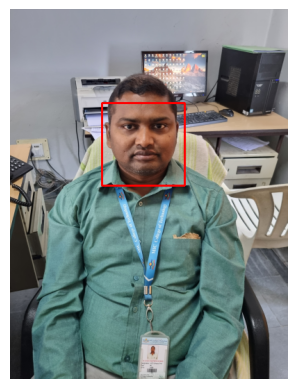





DETECTED FACIAL LANDMARKS


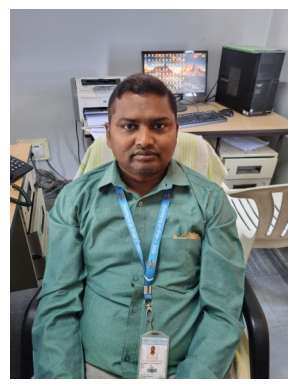





DETECTED PERIOCULAR REGIONS


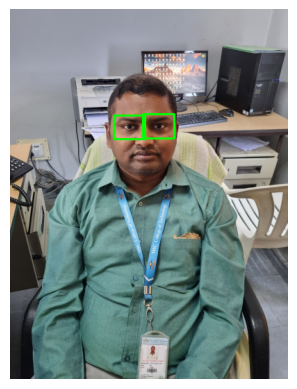





CROPPED PERIOCULAR REGIONS


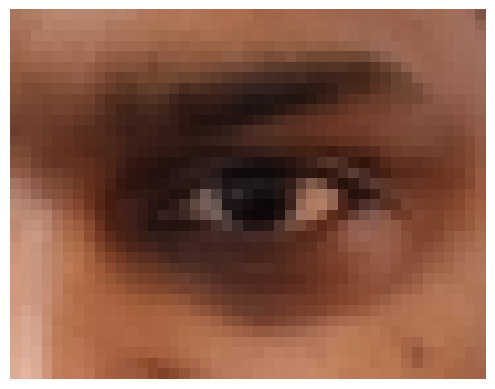

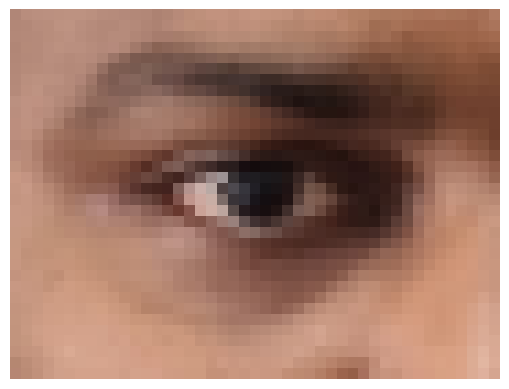





CLAHE PERFORMED



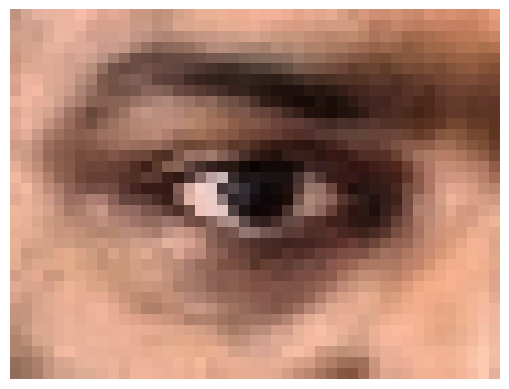





CLAHE PERFORMED



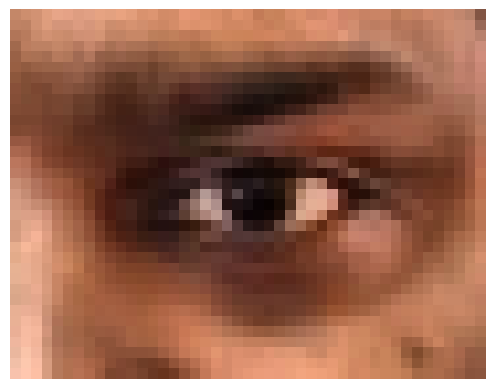





1/1 [==============================] - 0s 463ms/step


127.0.0.1 - - [24/Mar/2025 11:37:30] "GET /run.html?filename=20250301_122842.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:30] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:30] "GET /static/p.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:32] "GET /pr.html HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:32] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:32] "GET /static/p.jpg HTTP/1.1" 404 -


[102, 135, 231, 291]
DETECTED FACE REGION



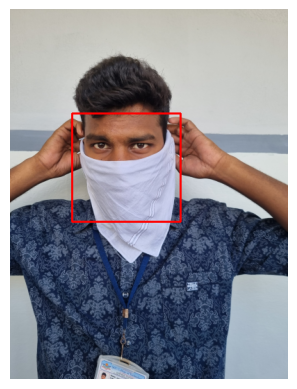





DETECTED FACIAL LANDMARKS


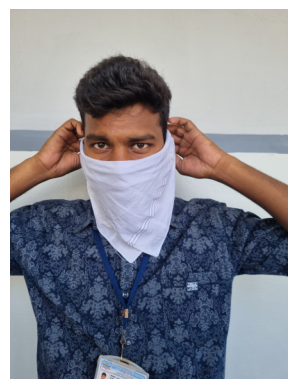





DETECTED PERIOCULAR REGIONS


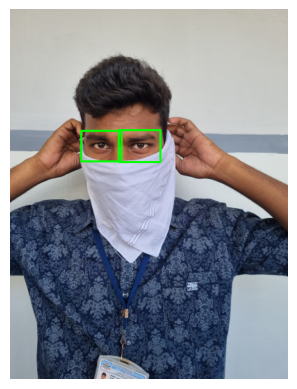





CROPPED PERIOCULAR REGIONS


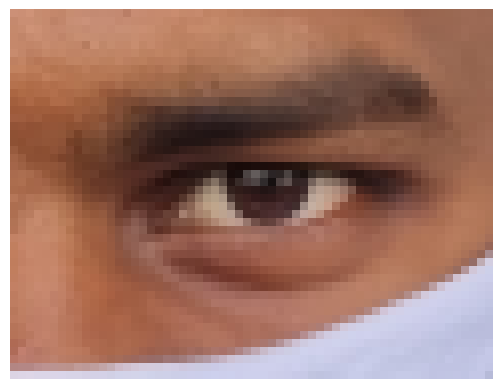

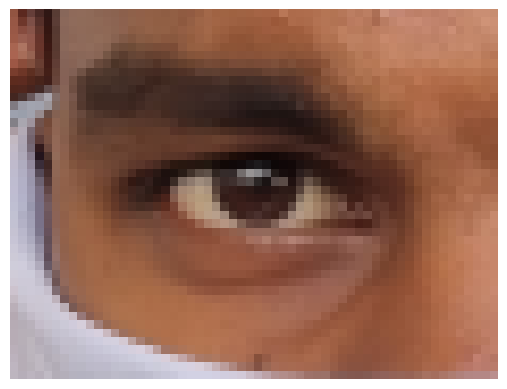





CLAHE PERFORMED



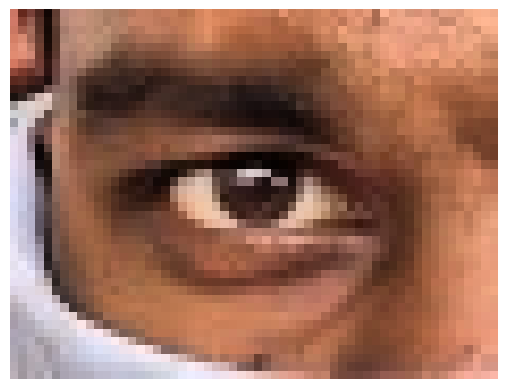





CLAHE PERFORMED



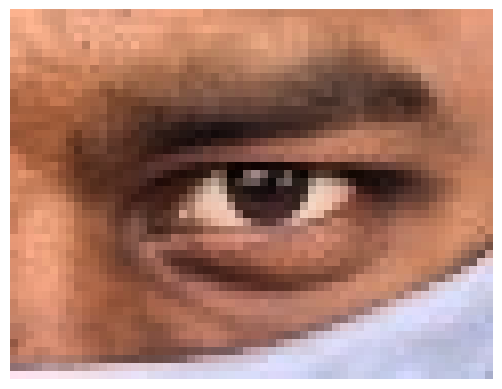





1/1 [==============================] - 1s 519ms/step


127.0.0.1 - - [24/Mar/2025 11:37:48] "GET /run.html?filename=20250301_123450.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:48] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:48] "GET /static/p.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:50] "GET /pr.html HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2025 11:37:50] "GET /static/pr.jpg HTTP/1.1" 404 -
127.0.0.1 - - [24/Mar/2025 11:37:50] "GET /static/p.jpg HTTP/1.1" 404 -


In [9]:
%cd drive/My Drive/Periocular_Recognition/Code/dataset1/precognition_ui
app = Flask(__name__, template_folder=r"C:\Users\sivak\Downloads\Periocular_Recognition-20250323T205204Z-001\Periocular_Recognition\Code\dataset1\precognition_ui\templates")
# run_with_ngrok(app)

@app.route("/")
def home():
    return render_template("ui.html")

@app.route("/ui.html")
def home1():
    return render_template("ui.html")

@app.route("/team.html")
def team():
    return render_template("team.html")

@app.route("/tech.html")
def tech():
  return render_template("tech.html")

@app.route("/about.html")
def about():
  return render_template("about.html")

@app.route("/registration.html")
def reg():
  return render_template("registration.html")

@app.route("/recog.html")
def recog():
  return render_template("recog.html")

@app.route("/pr.html")
def pr():
  return render_template("pr.html")

@app.route("/run.html", methods=['GET'])
# def file():
#   f = request.args.get('filename')
#   print(f)
#   for fm in os.listdir(test_dir):
#     if fm == f:
#       present = 1
#       break
#     else:
#       present =0
#   if present == 1:
#     fp = os.path.splitext(f)
#     if fp[1] == ".jpg" or fp[1]== ".png" or fp[1]== ".jpeg":
#       path = os.path.join(test_dir, f)
#       #print(path)
#       name = predict_person(path)
#       #print(name)
#       return render_template("run.html", name=name, f=f)
#     else:
#       return render_template("invfile.html")
#   else:
#     return render_template("mul_exist.html")
@app.route("/run.html", methods=['GET'])
def file():
  f = request.args.get('filename')
  #print(f)
  for fm in os.listdir(test_dir):
    if fm == f:
      present = 1
      break
    else:
      present =0
  if present == 1:
    fp = os.path.splitext(f)
    if fp[1] == ".jpg" or fp[1]== ".png" or fp[1]== ".jpeg":
      path = os.path.join(test_dir, f)
      #print(path)
      name = predict_person(path)
      #print(name)
      return render_template("run.html", name=name, f=f)
    else:
      return render_template("invfile.html")
  else:
    return render_template("mul_exist.html")

@app.route("/train.html")
def train():
  status = create_model()
  if status == "done":
    print("\n\n\n\n\n----------TRAINING DONE----------/n/n/n/n/n")
  return render_template("recog.html",accuracy="")

@app.route("/acc.html")
def acc():
  #uncomment the below line to render model accuracy in real time
  accuracy = get_model_accuracy()
  return render_template("recog.html",accuracy=accuracy)
app.run()